![image.png](https://i.imgur.com/a3uAqnb.png)

# 🚀 Transfer Learning Lab - PyTorch
---
### 🎯 **Lab Objectives:**
1. Understand **transfer learning** and why it's powerful 💪
2. Load and modify **pre-trained models** (ResNet18)
3. **Freeze layers** vs **fine-tuning** strategies
4. Compare performance between different approaches
5. Adapt models for **custom datasets**

---
### 📚 **What You'll Learn:**
- How to leverage pre-trained models for faster training
- When to freeze layers and when to fine-tune
- Practical techniques for adapting models to new tasks
- Performance comparison between transfer learning approaches

# **📌 What is Transfer Learning?**

**Transfer Learning** is like learning to ride a motorcycle after you already know how to ride a bicycle! 🚲➡️🏍️

## **🔹 The Concept**
Instead of training a model from scratch, we take a model that has **already learned useful features** from a large dataset (like ImageNet with 1M+ images) and adapt it to our specific task.

## **🔹 Why is Transfer Learning Powerful?**
| **Advantage** | **Explanation** | **Benefit** |
|--------------|-----------------|-------------|
| **⚡ Faster Training** | Pre-trained features don't need to be learned from scratch | Saves hours/days of training time |
| **🎯 Better Performance** | Features learned on large datasets are often very good | Higher accuracy with less data |
| **💾 Less Data Required** | Can work well even with small datasets | Perfect for real-world scenarios |
| **🔋 Lower Computational Cost** | Less GPU time and energy consumption | More accessible and eco-friendly |

## **🔹 Transfer Learning Strategies**
1. **🔒 Freeze Approach:** Keep pre-trained weights frozen, only train the classifier
2. **🔓 Fine-tune Approach:** Unfreeze some layers and train with lower learning rate
3. **⚖️ Hybrid Approach:** Start frozen, then fine-tune (best of both worlds!)

# **📌 Setup and Imports**

Let's start by importing all the necessary libraries and setting up our environment for Google Colab.

In [ ]:
# Essential imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

# For visualization and progress tracking
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import time

# Set up device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✅ All imports successful!")

🚀 Using device: cuda
✅ All imports successful!


# **📌 Dataset Class - CIFAR-10**

We'll use **CIFAR-10** dataset, which contains 60,000 32x32 color images in 10 classes.

## **🔹 CIFAR-10 Classes:**
0. ✈️ Airplane
1. 🚗 Automobile  
2. 🐦 Bird
3. 🐱 Cat
4. 🦌 Deer
5. 🐕 Dog
6. 🐸 Frog
7. 🐎 Horse
8. 🚢 Ship
9. 🚛 Truck

## **🔹 Important Note:**
For transfer learning, we need to **preprocess images** to match what the pre-trained model expects!

In [ ]:
# CIFAR-10 class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# 🔹 Data preprocessing for pre-trained models
# These values are ImageNet statistics that pre-trained models expect
transform_train = transforms.Compose([
    transforms.Resize(224),  # ResNet expects 224x224 images
    transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                        std=[0.229, 0.224, 0.225])    # ImageNet std
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# 🔹 Load CIFAR-10 dataset
print("📥 Downloading CIFAR-10 dataset...")
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

# Create data loaders
batch_size = 32  # Smaller batch size for transfer learning
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ Dataset loaded successfully!")
print(f"📊 Training samples: {len(train_dataset)}")
print(f"📊 Test samples: {len(test_dataset)}")
print(f"🎯 Number of classes: {len(class_names)}")

📥 Downloading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:05<00:00, 29.9MB/s]


✅ Dataset loaded successfully!
📊 Training samples: 50000
📊 Test samples: 10000
🎯 Number of classes: 10


# **📌 Let's Visualize Some Data!**

Before we start training, let's see what our data looks like! 👀

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


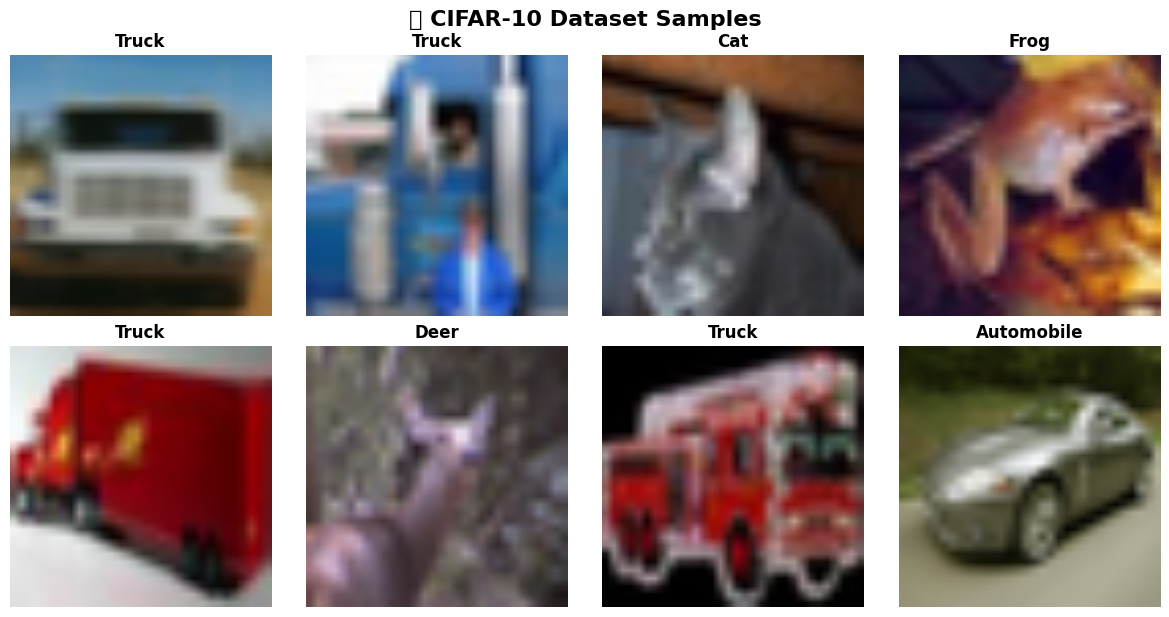

In [ ]:
def visualize_dataset_samples(dataset, class_names, num_samples=8):
    """
    Visualize random samples from the dataset
    """
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        image, label = dataset[idx]

        # Denormalize the image for visualization
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        image = image * std[:, None, None] + mean[:, None, None]
        image = torch.clamp(image, 0, 1)

        # Convert to numpy and transpose for matplotlib
        image_np = image.permute(1, 2, 0).numpy()

        axes[i].imshow(image_np)
        axes[i].set_title(f'{class_names[label]}', fontsize=12, fontweight='bold')
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle('🎯 CIFAR-10 Dataset Samples', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

# Visualize some samples
visualize_dataset_samples(train_dataset, class_names)

# **📌 Model Class - Pre-trained ResNet18**

Now let's create our model using **transfer learning**! We'll use ResNet18 pre-trained on ImageNet.

## **🔹 What is ResNet18?**
- **ResNet** = Residual Network
- **18** = Number of layers
- Pre-trained on **ImageNet** (1.2M images, 1000 classes)
- Excellent for **feature extraction**

In [ ]:
class TransferLearningModel(nn.Module):
    def __init__(self, num_classes=10, freeze_features=True):
        """
        Transfer Learning Model using ResNet18

        Args:
            num_classes: Number of output classes (10 for CIFAR-10)
            freeze_features: Whether to freeze feature extraction layers
        """
        super(TransferLearningModel, self).__init__()

        # 🔹 Load pre-trained ResNet18
        self.backbone = models.resnet18(pretrained=True)

        # 🔹 Freeze feature extraction layers if specified
        if freeze_features:
            for param in self.backbone.parameters():
                param.requires_grad = False
            print("🔒 Feature extraction layers frozen!")
        else:
            print("🔓 All layers will be fine-tuned!")

        # 🔹 Replace the final fully connected layer
        # Original ResNet18 has 1000 classes, we need 10 for CIFAR-10
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes)

        print(f"🎯 Model adapted for {num_classes} classes")
        print(f"🔧 Final layer: {num_features} → {num_classes}")

    def forward(self, x):
        """
        Forward pass through the model
        """
        return self.backbone(x)

    def unfreeze_layers(self, num_layers_to_unfreeze=2):
        """
        Unfreeze the last few layers for fine-tuning

        Args:
            num_layers_to_unfreeze: Number of final layers to unfreeze
        """
        # Get all layers
        layers = list(self.backbone.children())

        # Unfreeze the last few layers
        for layer in layers[-num_layers_to_unfreeze:]:
            for param in layer.parameters():
                param.requires_grad = True

        print(f"🔓 Unfroze last {num_layers_to_unfreeze} layers for fine-tuning!")

def count_parameters(model):
    """
    Count trainable and total parameters in the model
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"📊 Total parameters: {total_params:,}")
    print(f"🎯 Trainable parameters: {trainable_params:,}")
    print(f"🔒 Frozen parameters: {total_params - trainable_params:,}")
    print(f"📈 Trainable ratio: {100 * trainable_params / total_params:.1f}%")

    return total_params, trainable_params

# **📌 Training and Validation Functions**

Let's create our training and validation functions with progress tracking!

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train the model for one epoch
    """
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    # Progress bar
    pbar = tqdm(dataloader, desc="Training", leave=False)

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100 * correct / total:.2f}%'
        })

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

def validate(model, dataloader, criterion, device):
    """
    Validate the model
    """
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    # Progress bar
    pbar = tqdm(dataloader, desc="Validation", leave=False)

    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100 * correct / total:.2f}%'
            })

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

def train_model(model, train_loader, test_loader, criterion, optimizer,
                num_epochs, device, model_name="Model"):
    """
    Complete training loop with history tracking
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0
    start_time = time.time()

    print(f"\n🚀 Starting training: {model_name}")
    print("=" * 50)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

        # Validation
        val_loss, val_acc = validate(model, test_loader, criterion, device)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print results
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"🎉 New best validation accuracy: {best_val_acc:.2f}%")

    total_time = time.time() - start_time
    print(f"\n✅ Training completed in {total_time:.2f} seconds")
    print(f"🏆 Best validation accuracy: {best_val_acc:.2f}%")

    return history, best_val_acc

# **📌 Experiment 1: Frozen Feature Extractor**

Let's start with the **frozen approach** - we'll only train the classifier head! 🔒

In [ ]:
print("🔒 EXPERIMENT 1: Frozen Feature Extractor")
print("=" * 60)

# Create model with frozen features
model_frozen = TransferLearningModel(num_classes=10, freeze_features=True)
model_frozen = model_frozen.to(device)

# Count parameters
print("\n📊 Model Statistics:")
count_parameters(model_frozen)

# Setup training
criterion = nn.CrossEntropyLoss()
optimizer_frozen = optim.Adam(model_frozen.parameters(), lr=0.001)

# Train the model
history_frozen, best_acc_frozen = train_model(
    model_frozen, train_loader, test_loader, criterion,
    optimizer_frozen, num_epochs=5, device=device,
    model_name="Frozen Feature Extractor"
)

🔒 EXPERIMENT 1: Frozen Feature Extractor


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


🔒 Feature extraction layers frozen!
🎯 Model adapted for 10 classes
🔧 Final layer: 512 → 10

📊 Model Statistics:
📊 Total parameters: 11,181,642
🎯 Trainable parameters: 5,130
🔒 Frozen parameters: 11,176,512
📈 Trainable ratio: 0.0%

🚀 Starting training: Frozen Feature Extractor

Epoch 1/5


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.8019, Train Acc: 73.37%
Val Loss: 0.6207, Val Acc: 78.83%
🎉 New best validation accuracy: 78.83%

Epoch 2/5


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6411, Train Acc: 77.98%
Val Loss: 0.5761, Val Acc: 80.37%
🎉 New best validation accuracy: 80.37%

Epoch 3/5


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6186, Train Acc: 78.67%
Val Loss: 0.5737, Val Acc: 80.61%
🎉 New best validation accuracy: 80.61%

Epoch 4/5


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6088, Train Acc: 79.02%
Val Loss: 0.5808, Val Acc: 80.06%

Epoch 5/5


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6085, Train Acc: 79.06%
Val Loss: 0.5664, Val Acc: 80.63%
🎉 New best validation accuracy: 80.63%

✅ Training completed in 738.23 seconds
🏆 Best validation accuracy: 80.63%


# **📌 Experiment 2: Fine-tuning Approach**

Now let's try **fine-tuning** - we'll unfreeze some layers and train with a lower learning rate! 🔓

In [ ]:
print("\n🔓 EXPERIMENT 2: Fine-tuning Approach")
print("=" * 60)

# Create model without freezing
model_finetune = TransferLearningModel(num_classes=10, freeze_features=False)
model_finetune = model_finetune.to(device)

# Count parameters
print("\n📊 Model Statistics:")
count_parameters(model_finetune)

# Setup training with lower learning rate for fine-tuning
criterion = nn.CrossEntropyLoss()
optimizer_finetune = optim.Adam(model_finetune.parameters(), lr=0.0001)  # Lower LR!

# Train the model
history_finetune, best_acc_finetune = train_model(
    model_finetune, train_loader, test_loader, criterion,
    optimizer_finetune, num_epochs=5, device=device,
    model_name="Fine-tuning All Layers"
)


🔓 EXPERIMENT 2: Fine-tuning Approach
🔓 All layers will be fine-tuned!
🎯 Model adapted for 10 classes
🔧 Final layer: 512 → 10

📊 Model Statistics:
📊 Total parameters: 11,181,642
🎯 Trainable parameters: 11,181,642
🔒 Frozen parameters: 0
📈 Trainable ratio: 100.0%

🚀 Starting training: Fine-tuning All Layers

Epoch 1/5


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.3361, Train Acc: 88.87%
Val Loss: 0.2159, Val Acc: 92.89%
🎉 New best validation accuracy: 92.89%

Epoch 2/5


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.1659, Train Acc: 94.47%
Val Loss: 0.1814, Val Acc: 94.01%
🎉 New best validation accuracy: 94.01%

Epoch 3/5


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.1114, Train Acc: 96.25%
Val Loss: 0.1812, Val Acc: 93.65%

Epoch 4/5


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.0874, Train Acc: 97.12%
Val Loss: 0.1964, Val Acc: 93.67%

Epoch 5/5


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.0706, Train Acc: 97.60%
Val Loss: 0.1759, Val Acc: 94.61%
🎉 New best validation accuracy: 94.61%

✅ Training completed in 1221.19 seconds
🏆 Best validation accuracy: 94.61%


# **📌 Experiment 3: Hybrid Approach**

The **best approach** - start frozen, then unfreeze and fine-tune! ⚖️

In [ ]:
print("\n⚖️ EXPERIMENT 3: Hybrid Approach (Frozen → Fine-tune)")
print("=" * 60)

# Create model with frozen features initially
model_hybrid = TransferLearningModel(num_classes=10, freeze_features=True)
model_hybrid = model_hybrid.to(device)

criterion = nn.CrossEntropyLoss()

# Phase 1: Train with frozen features (3 epochs)
print("\n🔒 PHASE 1: Training with frozen features (3 epochs)")
optimizer_phase1 = optim.Adam(model_hybrid.parameters(), lr=0.001)

history_phase1, _ = train_model(
    model_hybrid, train_loader, test_loader, criterion,
    optimizer_phase1, num_epochs=3, device=device,
    model_name="Hybrid - Phase 1 (Frozen)"
)

# Phase 2: Unfreeze last 2 layers and fine-tune (3 epochs)
print("\n🔓 PHASE 2: Unfreezing last 2 layers and fine-tuning (3 epochs)")
model_hybrid.unfreeze_layers(num_layers_to_unfreeze=2)
count_parameters(model_hybrid)

optimizer_phase2 = optim.Adam(model_hybrid.parameters(), lr=0.0001)  # Lower LR

history_phase2, best_acc_hybrid = train_model(
    model_hybrid, train_loader, test_loader, criterion,
    optimizer_phase2, num_epochs=3, device=device,
    model_name="Hybrid - Phase 2 (Fine-tune)"
)

# Combine histories
history_hybrid = {
    'train_loss': history_phase1['train_loss'] + history_phase2['train_loss'],
    'train_acc': history_phase1['train_acc'] + history_phase2['train_acc'],
    'val_loss': history_phase1['val_loss'] + history_phase2['val_loss'],
    'val_acc': history_phase1['val_acc'] + history_phase2['val_acc']
}


⚖️ EXPERIMENT 3: Hybrid Approach (Frozen → Fine-tune)
🔒 Feature extraction layers frozen!
🎯 Model adapted for 10 classes
🔧 Final layer: 512 → 10

🔒 PHASE 1: Training with frozen features (3 epochs)

🚀 Starting training: Hybrid - Phase 1 (Frozen)

Epoch 1/3


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.7991, Train Acc: 73.41%
Val Loss: 0.6188, Val Acc: 79.08%
🎉 New best validation accuracy: 79.08%

Epoch 2/3


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6390, Train Acc: 78.01%
Val Loss: 0.5841, Val Acc: 80.32%
🎉 New best validation accuracy: 80.32%

Epoch 3/3


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6215, Train Acc: 78.36%
Val Loss: 0.5824, Val Acc: 80.22%

✅ Training completed in 445.42 seconds
🏆 Best validation accuracy: 80.32%

🔓 PHASE 2: Unfreezing last 2 layers and fine-tuning (3 epochs)
🔓 Unfroze last 2 layers for fine-tuning!
📊 Total parameters: 11,181,642
🎯 Trainable parameters: 5,130
🔒 Frozen parameters: 11,176,512
📈 Trainable ratio: 0.0%

🚀 Starting training: Hybrid - Phase 2 (Fine-tune)

Epoch 1/3


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.5778, Train Acc: 80.08%
Val Loss: 0.5640, Val Acc: 80.89%
🎉 New best validation accuracy: 80.89%

Epoch 2/3


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.5749, Train Acc: 80.08%
Val Loss: 0.5585, Val Acc: 81.19%
🎉 New best validation accuracy: 81.19%

Epoch 3/3


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.5762, Train Acc: 80.05%
Val Loss: 0.5562, Val Acc: 81.19%

✅ Training completed in 446.25 seconds
🏆 Best validation accuracy: 81.19%


# **📌 Results Comparison and Visualization**

Let's compare all three approaches! 📊

/tmp/ipython-input-9-2852276324.py:54: UserWarning: Glyph 128274 (\N{LOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-9-2852276324.py:54: UserWarning: Glyph 128275 (\N{OPEN LOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-9-2852276324.py:54: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128274 (\N{LOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128275 (\N{OPEN LOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


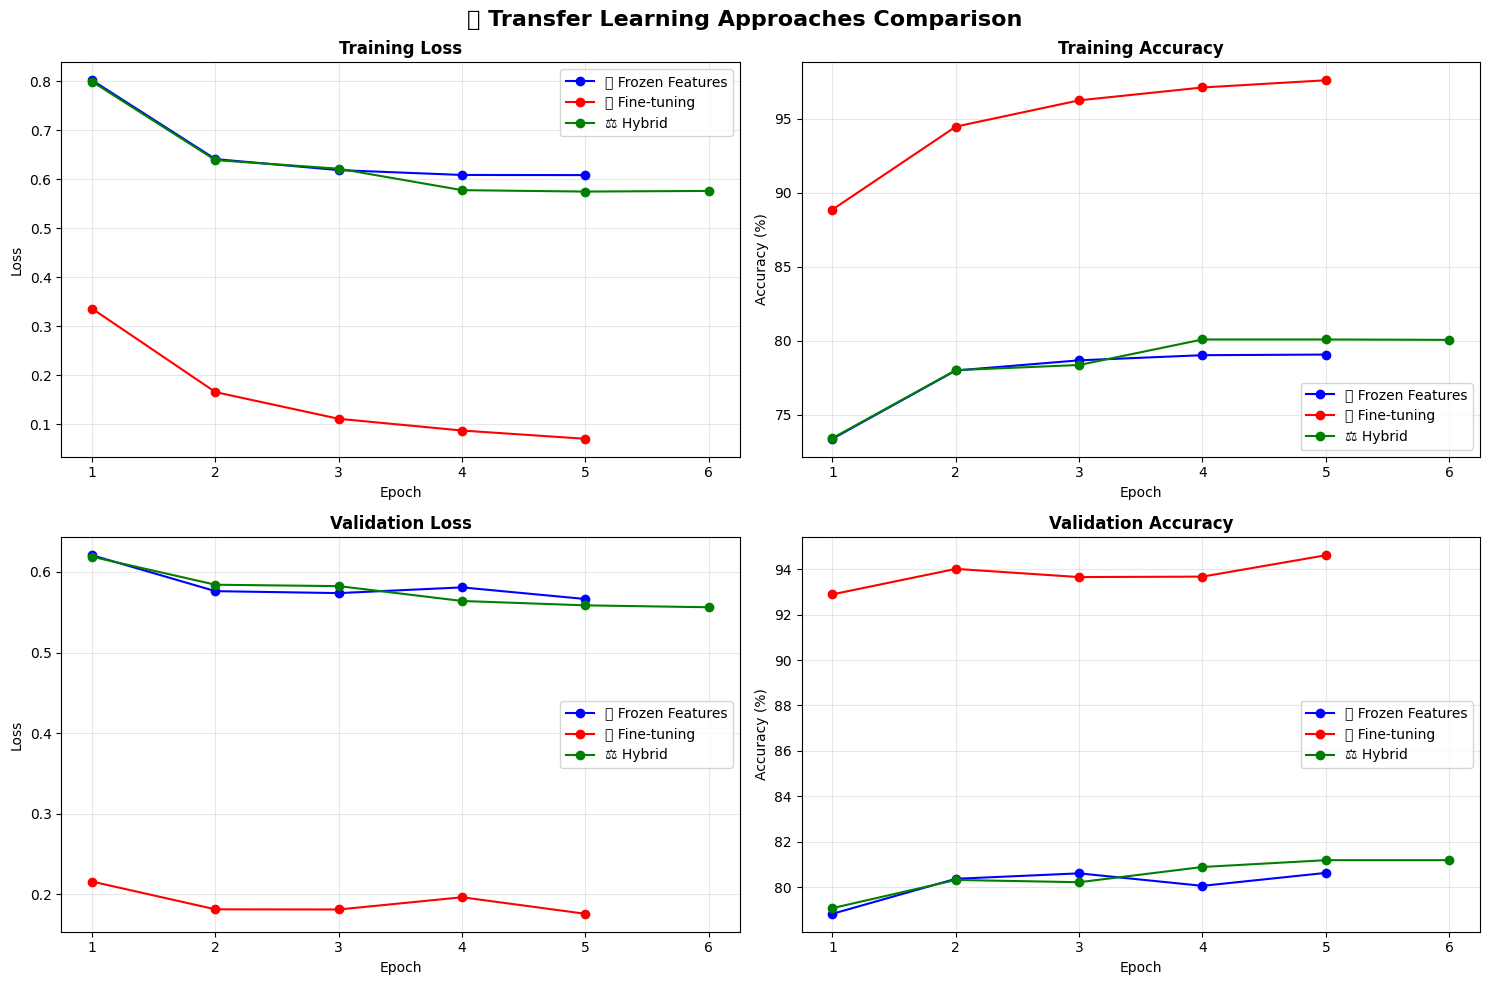

In [ ]:
def plot_training_comparison(histories, labels, title="Training Comparison"):
    """
    Plot training and validation metrics for multiple models
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    colors = ['blue', 'red', 'green']

    # Training Loss
    axes[0, 0].set_title('Training Loss', fontweight='bold')
    for i, (history, label) in enumerate(zip(histories, labels)):
        epochs = range(1, len(history['train_loss']) + 1)
        axes[0, 0].plot(epochs, history['train_loss'],
                       color=colors[i], label=label, marker='o')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Training Accuracy
    axes[0, 1].set_title('Training Accuracy', fontweight='bold')
    for i, (history, label) in enumerate(zip(histories, labels)):
        epochs = range(1, len(history['train_acc']) + 1)
        axes[0, 1].plot(epochs, history['train_acc'],
                       color=colors[i], label=label, marker='o')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Validation Loss
    axes[1, 0].set_title('Validation Loss', fontweight='bold')
    for i, (history, label) in enumerate(zip(histories, labels)):
        epochs = range(1, len(history['val_loss']) + 1)
        axes[1, 0].plot(epochs, history['val_loss'],
                       color=colors[i], label=label, marker='o')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Validation Accuracy
    axes[1, 1].set_title('Validation Accuracy', fontweight='bold')
    for i, (history, label) in enumerate(zip(histories, labels)):
        epochs = range(1, len(history['val_acc']) + 1)
        axes[1, 1].plot(epochs, history['val_acc'],
                       color=colors[i], label=label, marker='o')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Compare all approaches
histories = [history_frozen, history_finetune, history_hybrid]
labels = ['🔒 Frozen Features', '🔓 Fine-tuning', '⚖️ Hybrid']

plot_training_comparison(histories, labels, "🏆 Transfer Learning Approaches Comparison")

# **📌 Final Results Summary**

Let's summarize our findings! 📋

In [ ]:
print("\n" + "=" * 60)
print("🏆 FINAL RESULTS SUMMARY")
print("=" * 60)

results_data = [
    ["🔒 Frozen Features", f"{best_acc_frozen:.2f}%", "Fast, Less overfitting"],
    ["🔓 Fine-tuning", f"{best_acc_finetune:.2f}%", "Higher capacity, More parameters"],
    ["⚖️ Hybrid", f"{best_acc_hybrid:.2f}%", "Best of both worlds"]
]

print(f"{'Approach':<20} {'Best Val Acc':<15} {'Characteristics'}")
print("-" * 60)
for approach, acc, char in results_data:
    print(f"{approach:<20} {acc:<15} {char}")

# Find the best approach
best_accuracies = [best_acc_frozen, best_acc_finetune, best_acc_hybrid]
best_idx = np.argmax(best_accuracies)
best_approach = ["Frozen Features", "Fine-tuning", "Hybrid"][best_idx]

print(f"\n🥇 WINNER: {best_approach} with {max(best_accuracies):.2f}% accuracy!")

print("\n📊 Key Insights:")
print("• Frozen approach is fastest and prevents overfitting")
print("• Fine-tuning can achieve higher accuracy but requires more careful tuning")
print("• Hybrid approach often provides the best balance")
print("• Transfer learning beats training from scratch! 🚀")


🏆 FINAL RESULTS SUMMARY
Approach             Best Val Acc    Characteristics
------------------------------------------------------------
🔒 Frozen Features    80.63%          Fast, Less overfitting
🔓 Fine-tuning        94.61%          Higher capacity, More parameters
⚖️ Hybrid            81.19%          Best of both worlds

🥇 WINNER: Fine-tuning with 94.61% accuracy!

📊 Key Insights:
• Frozen approach is fastest and prevents overfitting
• Fine-tuning can achieve higher accuracy but requires more careful tuning
• Hybrid approach often provides the best balance
• Transfer learning beats training from scratch! 🚀


# **📌 Testing Our Best Model**

Let's test our best model on some random samples and visualize the predictions! 🔍

🔍 Testing our best model on random samples:


/tmp/ipython-input-11-1347274375.py:56: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-1347274375.py:56: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-1347274375.py:56: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu San

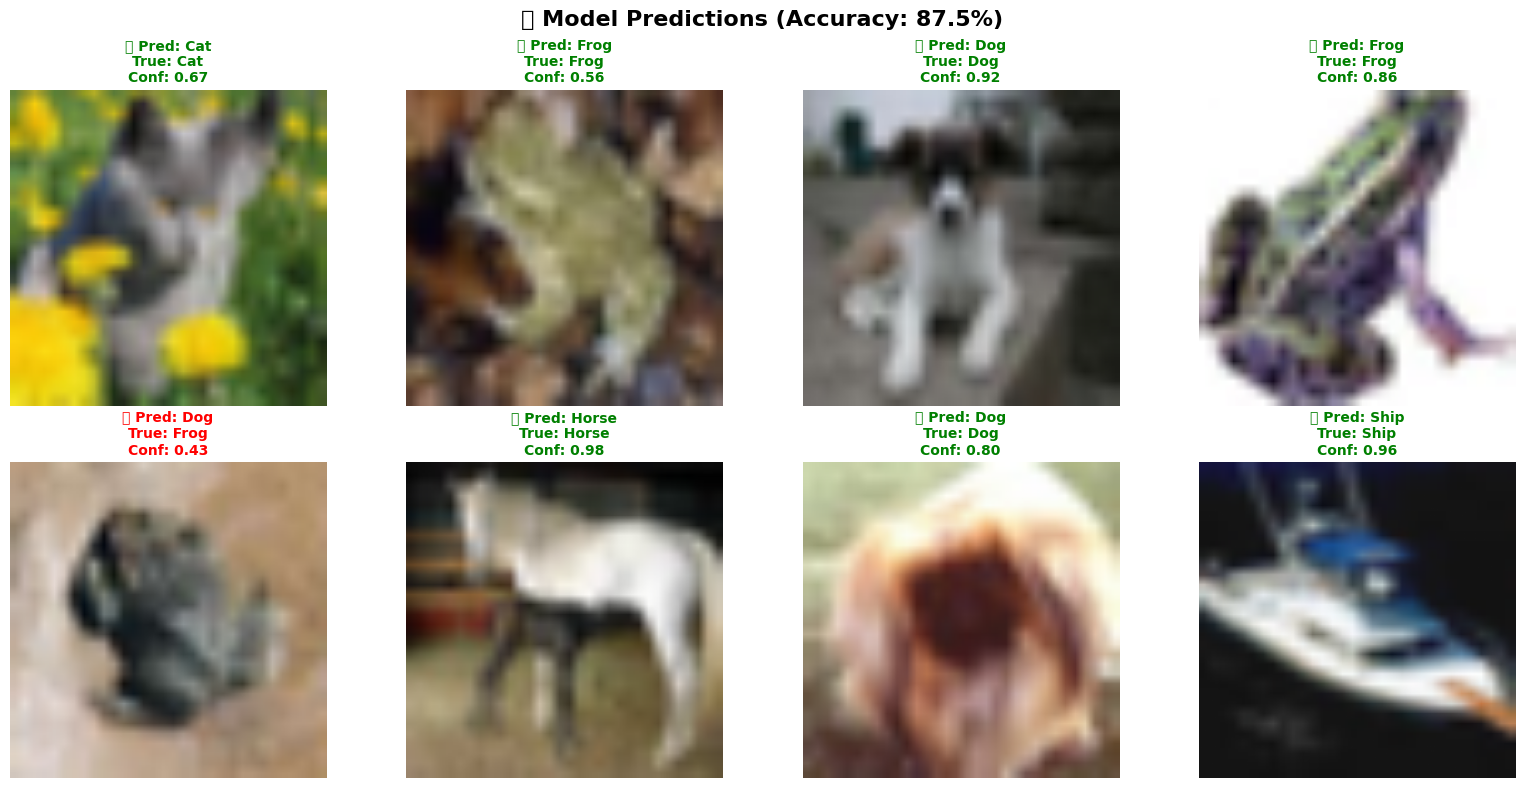


📊 Sample test accuracy: 87.5%


In [ ]:
def visualize_predictions(model, dataset, class_names, device, num_samples=8):
    """
    Visualize model predictions on random samples
    """
    model.eval()

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    correct_predictions = 0

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_label = dataset[idx]

            # Make prediction
            image_batch = image.unsqueeze(0).to(device)  # Add batch dimension
            output = model(image_batch)
            probabilities = F.softmax(output, dim=1)
            predicted_label = torch.argmax(output, dim=1).item()
            confidence = probabilities[0][predicted_label].item()

            # Denormalize image for visualization
            mean = torch.tensor([0.485, 0.456, 0.406])
            std = torch.tensor([0.229, 0.224, 0.225])
            image_vis = image * std[:, None, None] + mean[:, None, None]
            image_vis = torch.clamp(image_vis, 0, 1)
            image_np = image_vis.permute(1, 2, 0).numpy()

            # Plot
            axes[i].imshow(image_np)

            # Set title with prediction info
            is_correct = predicted_label == true_label
            if is_correct:
                correct_predictions += 1
                title_color = 'green'
                status = '✅'
            else:
                title_color = 'red'
                status = '❌'

            title = f"{status} Pred: {class_names[predicted_label]}\n" \
                   f"True: {class_names[true_label]}\n" \
                   f"Conf: {confidence:.2f}"

            axes[i].set_title(title, fontsize=10, color=title_color, fontweight='bold')
            axes[i].axis('off')

    accuracy = 100 * correct_predictions / num_samples
    plt.suptitle(f'🔍 Model Predictions (Accuracy: {accuracy:.1f}%)',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return accuracy

# Test the best model (let's use hybrid for this example)
print("🔍 Testing our best model on random samples:")
test_accuracy = visualize_predictions(model_hybrid, test_dataset, class_names, device)
print(f"\n📊 Sample test accuracy: {test_accuracy:.1f}%")

# **📌 Practice Exercises**

Now it's your turn to experiment! 💪

## **🎯 Exercise 1: Different Pre-trained Models**
Try different pre-trained models and compare their performance:

In [ ]:
# 🎯 EXERCISE 1: Try ResNet34 instead of ResNet18
# TODO: Modify the TransferLearningModel class to use ResNet34
# Hint: Change models.resnet18 to models.resnet34

# Your code here:
class TransferLearningModelResNet34(nn.Module):
    def __init__(self, num_classes=10, freeze_features=True):
        super(TransferLearningModelResNet34, self).__init__()

        # TODO: Load ResNet34 instead of ResNet18
        # self.backbone = models.resnet34(pretrained=True)  # <-- Uncomment and complete

        # TODO: Complete the rest of the implementation
        pass

    def forward(self, x):
        # TODO: Implement forward pass
        pass

# Test your implementation:
# model_resnet34 = TransferLearningModelResNet34()
# count_parameters(model_resnet34)

print("💡 Hint: ResNet34 has more parameters than ResNet18. What do you expect to happen?")

💡 Hint: ResNet34 has more parameters than ResNet18. What do you expect to happen?


## **🎯 Exercise 2: Different Learning Rates**
Experiment with different learning rates for fine-tuning:

In [ ]:
# 🎯 EXERCISE 2: Test different learning rates
# TODO: Train models with different learning rates and compare results

learning_rates = [0.01, 0.001, 0.0001, 0.00001]
results = {}

print("🧪 Testing different learning rates...")
print("(This might take a while - you can reduce epochs for faster testing)")

# TODO: Complete this experiment
for lr in learning_rates[:2]:  # Test first 2 LRs to save time
    print(f"\n📈 Testing learning rate: {lr}")

    # Create model
    # model = TransferLearningModel(num_classes=10, freeze_features=False)
    # model = model.to(device)

    # Setup optimizer with current learning rate
    # optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train for 2 epochs (quick test)
    # history, best_acc = train_model(model, train_loader, test_loader,
    #                                criterion, optimizer, num_epochs=2,
    #                                device=device, model_name=f"LR_{lr}")
    # results[lr] = best_acc

    pass  # Remove this when you implement

# TODO: Print results comparison
print("\n📊 Learning Rate Comparison:")
# for lr, acc in results.items():
#     print(f"LR {lr}: {acc:.2f}%")

print("💭 Question: Which learning rate worked best? Why do you think that is?")

🧪 Testing different learning rates...
(This might take a while - you can reduce epochs for faster testing)

📈 Testing learning rate: 0.01

📈 Testing learning rate: 0.001

📊 Learning Rate Comparison:
💭 Question: Which learning rate worked best? Why do you think that is?


## **🎯 Exercise 3: Custom Classifier Head**
Design a more complex classifier head:

In [ ]:
# 🎯 EXERCISE 3: Create a custom classifier head
# TODO: Instead of just one Linear layer, create a more complex classifier

class CustomClassifierHead(nn.Module):
    def __init__(self, input_features, num_classes, dropout_rate=0.5):
        super(CustomClassifierHead, self).__init__()

        # TODO: Design a classifier with:
        # 1. Linear layer (input_features -> 256)
        # 2. ReLU activation
        # 3. Dropout
        # 4. Linear layer (256 -> 128)
        # 5. ReLU activation
        # 6. Dropout
        # 7. Final Linear layer (128 -> num_classes)

        self.classifier = nn.Sequential(
            # TODO: Add your layers here
            # nn.Linear(input_features, 256),
            # nn.ReLU(),
            # ...
        )

    def forward(self, x):
        return self.classifier(x)

# TODO: Modify TransferLearningModel to use CustomClassifierHead
# Hint: Replace self.backbone.fc = nn.Linear(...) with your custom head

print("💡 Hint: A more complex classifier might help with complex datasets!")
print("🤔 Question: What are the pros and cons of a more complex classifier?")

💡 Hint: A more complex classifier might help with complex datasets!
🤔 Question: What are the pros and cons of a more complex classifier?


# **📌 Key Takeaways and Summary**

🎉 **Congratulations!** You've completed the Transfer Learning Lab!

## **🔹 What You've Learned:**

### **🧠 Conceptual Understanding:**
- **Transfer Learning:** Leveraging pre-trained models for new tasks
- **Feature Extraction:** Using frozen pre-trained layers
- **Fine-tuning:** Updating pre-trained weights with lower learning rates
- **Hybrid Approach:** Combining both strategies for optimal results

### **🛠️ Technical Skills:**
- Loading and modifying pre-trained models
- Freezing and unfreezing model parameters
- Proper preprocessing for pre-trained models
- Comparing different training strategies
- Visualizing training progress and predictions

### **📊 Best Practices:**
1. **Start with frozen features** for quick initial training
2. **Use lower learning rates** when fine-tuning
3. **Proper data preprocessing** is crucial for pre-trained models
4. **Monitor both training and validation metrics**
5. **Hybrid approach** often provides the best results

## **🔹 When to Use Transfer Learning:**
- ✅ **Limited training data** (< 10,000 samples)
- ✅ **Similar domain** (ImageNet → natural images)
- ✅ **Time/resource constraints**
- ✅ **Need quick baseline** for comparison

## **🔹 Transfer Learning in the Real World:**
- **Medical imaging:** X-ray analysis, MRI interpretation
- **Autonomous vehicles:** Object detection, lane recognition
- **Agriculture:** Crop disease detection, yield prediction
- **Retail:** Product recognition, quality control
- **Social media:** Content moderation, image tagging

---

## **🎯 Next Steps:**
1. **Try different datasets** (CIFAR-100, ImageNet subset)
2. **Experiment with other architectures** (VGG, DenseNet, EfficientNet)
3. **Learn about domain adaptation** for very different domains
4. **Explore self-supervised learning** for even better pre-training
5. **Apply transfer learning to your own projects!**

---

### **💭 Reflection Questions:**
1. Which transfer learning approach worked best for you and why?
2. How much faster was transfer learning compared to training from scratch?
3. What challenges did you face when implementing transfer learning?
4. How would you adapt this approach for a completely different domain?

---

**🎉 Well done! You're now ready to apply transfer learning to real-world problems!**

### 🧠 **Contributed by: AI Education Team**
### 📚 **Based on PyTorch Official Documentation and Best Practices**